In [1]:
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model

2025-08-05 03:55:52.283850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 03:55:52.409825: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 03:55:52.443652: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
In_name = "TS_anom" #
Out_name = "FLNT_anom" #
#Out_name = "TOA_anom" #


#====================== Here is 1D data ===============================#
# Paths to the datasets
# file_hist = "E:\\Yue\\CESM2\\test\\test.CESM2-historical.ens-mean.ANN.1850-2014.new.nc"
# file_2xCO2 = "E:\\Yue\\test\\test.2xCO2.ANN.new.nc"
# file_4xCO2 = "E:\\Yue\\CESM2\\test\\test.CESM2-4xCO2.ANN.nc"

'''
######### CESM1 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.FLNT.ANN.new.nc"
######### CESM1 #########

'''
######### CESM2 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.FLNT.ANN.nc"
#file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
######### CESM2 #########

#====================== End of 1D data ================================#

#====================== here is 2D data ===============================#

#====================== End of 1D data ================================#

# === Load historical data ===
ds_hist = xr.open_dataset(file_hist, engine="netcdf4")
print("Historical dataset loaded:", ds_hist)

Historical dataset loaded: <xarray.Dataset>
Dimensions:   (time: 165, lon: 288, lat: 192)
Coordinates:
  * time      (time) object 1850-06-16 00:00:00 ... 2014-06-16 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float64 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
Attributes:
    ERF:      ERF = F - F_ctrl (from Isla's ERFMIP runs)
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
    author:   Y. Dong, 04/02/2025


In [3]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 

######### CESM2 #########
time_hist = [date.year for date in time_hist.values] #for C2 data
######### CESM2 #########

######### CESM1 #########
#time_hist = time_hist.values #for C1 data
######### CESM1 #########

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist["TOA_anom"].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2, engine="netcdf4")
print("4xCO2 dataset loaded:", ds_4xCO2)


# time_4xCO2_coords = ds_4xCO2["year"]
# time_4xCO2 = time_4xCO2_coords.values


######### CESM2 #########
time_4xCO2 = ds_4xCO2["time"] 
time_4xCO2 = [date.year for date in time_4xCO2.values] #for C2 data
######### CESM2 #########
'''
######### CESM1 #########
time_4xCO2 = ds_4xCO2["year"] 
time_4xCO2 = time_4xCO2.values #C1 data
######### CESM1 #########
'''

TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# Optional: Print shapes to verify
print("TS_hist shape:", TS_hist.shape)
# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:    (time: 150, lon: 288, lat: 192)
Coordinates:
  * time       (time) object 0001-06-16 00:00:00 ... 0150-06-16 00:00:00
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS_anom    (time, lat, lon) float64 ...
    FLNT_anom  (time) float64 ...
Attributes:
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
    note:     all fluxes are positive downward (TOA = FSNT + FLNT)
TS_hist shape: (165, 192, 288)
TS_4xCO2 shape: (150, 192, 288)


In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import ndimage # New import for spatial smoothing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def calculate_trend_and_significance_temporal_smooth(relevance_data, time_axis, p_value_threshold=0.05, window_size=5):
    """
    Applies temporal smoothing (running mean) to relevance time series before
    calculating the linear trend and significance.
    'window_size' is the number of years for the running mean.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    num_time, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool)

    print(f"    Calculating trends with temporal smoothing (window={window_size}) for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            
            if np.all(np.isfinite(relevance_timeseries)):
                # Apply temporal smoothing using a rolling mean
                # Using pandas for convenient rolling mean with handling of edges
                series = pd.Series(relevance_timeseries)
                smoothed_timeseries = series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
                
                # Filter out NaNs that might be introduced by rolling mean if window is large
                valid_indices = ~np.isnan(smoothed_timeseries)
                
                if np.sum(valid_indices) > 1: # Need at least 2 points for regression
                    current_time_axis = time_axis[valid_indices]
                    current_data = smoothed_timeseries[valid_indices]
                    
                    if len(current_data) > 1: # Still need at least 2 points after NaN removal
                        lin_reg_result = stats.linregress(x=current_time_axis, y=current_data)
                        trend_map[y, x] = lin_reg_result.slope
                        if lin_reg_result.pvalue < p_value_threshold:
                            significance_mask[y, x] = True
    print("    Trend and significance calculation with temporal smoothing complete.")
    return trend_map, significance_mask

def calculate_trend_and_significance(relevance_data, time_axis, p_value_threshold=0.1):
    """
    Calculates the linear trend (slope) and a significance mask
    at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool) # Mask for significance

    print(f"    Calculating trends and significance for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                lin_reg_result = stats.linregress(x=time_axis, y=relevance_timeseries)
                trend_map[y, x] = lin_reg_result.slope
                if lin_reg_result.pvalue < p_value_threshold:
                    significance_mask[y, x] = True
    print("    Trend and significance calculation complete.")
    return trend_map, significance_mask

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    smoothed_map = ndimage.gaussian_filter(data2d, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

In [6]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float64]
Coordinates:
    time     object 1850-06-16 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850 yr1001-2000 mean

In [7]:
### load the mean and STD calculated in the Pre-industrial control run for normalization

# Paths to the datasets and trained model


########### CESM1 Model ##########
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #original model

#C1 FLNT
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_for_FLNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FLNT"

#new model(1) -wrong one
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #wrong place but the model is for data 1
######### CESM1 #########

########## CESM2 Model ######
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_for_FSNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FSNT"
#FLNT
path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_for_FLNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FLNT_anom"
######### CESM2 #########

normalization= sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))

X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']


TS_hist_norm = (TS_hist-X_mean)/X_std.squeeze()
# TS_2xCO2_norm = (TS_2xCO2-X_mean)/X_std.squeeze()
TS_4xCO2_norm = (TS_4xCO2-X_mean)/X_std.squeeze()

TS_hist_norm = TS_hist_norm.values[..., tf.newaxis]
# TS_2xCO2_norm = TS_2xCO2_norm.values[..., tf.newaxis]
TS_4xCO2_norm = TS_4xCO2_norm.values[..., tf.newaxis]

print(X_mean)
print(X_std)

[[ 2.69134529e-04  2.70034798e-04  2.68928532e-04 ...  2.68775941e-04
   2.67318712e-04  2.68577569e-04]
 [ 1.57882692e-04  2.20359798e-04 -2.64068600e-04 ... -1.64413446e-04
  -2.00347895e-05 -1.07162472e-04]
 [ 2.44621275e-04  3.30581679e-05  1.78253176e-04 ...  1.27799984e-04
   5.52215570e-05  2.28050238e-04]
 ...
 [ 3.63540639e-05  1.60194395e-04 -2.46505748e-04 ... -1.08673099e-04
   1.35780341e-04 -5.63964859e-05]
 [-2.83660884e-05  2.01332092e-04 -2.97416700e-04 ... -1.89628598e-04
   9.64813225e-05  5.96618665e-05]
 [ 1.31935114e-04  1.05911255e-04  4.40216081e-06 ...  2.38952634e-05
   3.19442734e-05  1.20666504e-04]]
[[0.7050085  0.7050056  0.70500815 ... 0.7050045  0.7050065  0.70500964]
 [0.74037796 0.7402206  0.7401302  ... 0.7406541  0.7405854  0.74052644]
 [0.76330787 0.7628695  0.762435   ... 0.76452696 0.76414007 0.76372325]
 ...
 [1.0075833  1.0097357  1.0118269  ... 1.0020813  1.00389    1.0056254 ]
 [0.9827776  0.9835799  0.9844185  ... 0.9801279  0.9810325  0.9819

In [8]:
from tensorflow.keras import backend as K
# load the neural network trained from Pre-industrial control simulation

n_folds = 5
n_ensembles = 1

pred_hist_ALL = np.empty((TOA_hist.shape[0],0))
# pred_2xCO2_ALL = np.empty((TOA_2xCO2.shape[0],0))
pred_4xCO2_ALL = np.empty((TOA_4xCO2.shape[0],0))


for fold_no in range(1,n_folds+1):

    pred_hist = np.zeros((TOA_hist.shape[0],1));
    # pred_2xCO2 = np.zeros((TOA_2xCO2.shape[0],1));
    pred_4xCO2 = np.zeros((TOA_4xCO2.shape[0],1));
    for ens_no in range(1,n_ensembles+1):
        K.clear_session() # Clears the Keras session and TensorFlow graph
        gc.collect()  
        Model = load_model(os.path.join(path_PIc,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
        pred_hist = pred_hist+ Model.predict(TS_hist_norm)
        # pred_2xCO2 = pred_2xCO2+ Model.predict(TS_2xCO2_norm)
        pred_4xCO2 = pred_4xCO2+ Model.predict(TS_4xCO2_norm)
        
    pred_hist = pred_hist/n_ensembles
    # pred_2xCO2 = pred_2xCO2/n_ensembles
    pred_4xCO2 = pred_4xCO2/n_ensembles


# re-scale the prediction from the neural network
    pred_hist = pred_hist*y_std + y_mean
    # pred_2xCO2 = pred_2xCO2*y_std + y_mean
    pred_4xCO2 = pred_4xCO2*y_std + y_mean



    pred_hist_ALL = np.concatenate(( pred_hist_ALL,pred_hist),axis = 1)
    # pred_2xCO2_ALL = np.concatenate(( pred_2xCO2_ALL,pred_2xCO2),axis = 1)
    pred_4xCO2_ALL = np.concatenate(( pred_4xCO2_ALL,pred_4xCO2),axis = 1)




2025-08-05 03:56:01.576948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 03:56:02.046945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2025-08-05 03:56:02.053823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-08-05 03:56:03.172209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2025-08-05 03:56:04.563793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica

In [9]:
def plot_predictions(time, truth, preds, title):
    """
    Plots the ground truth, mean prediction, and individual model predictions with transparency.

    Parameters:
        time (array-like): Time axis values.
        truth (array-like): Ground truth values.
        preds (2D array): Predictions from ensemble or multiple models (shape: time x ensemble).
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot truth
    ax.plot(time, truth, label="Truth", color="C0", linewidth=2)

    # Plot mean prediction
    mean_pred = np.mean(preds, axis=1)
    ax.plot(time, mean_pred, label="Prediction (Mean)", color="C1", linewidth=1.8)

    # Plot individual models
    for i in range(preds.shape[1]):
        ax.plot(time, preds[:, i], linewidth=1, alpha=0.5,
                label="Prediction (CV" + str(i+1) + ")")

    # Style
    ax.set_xlabel("Time (Year)", fontsize=16)
    ax.set_ylabel(Out_name, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=18, pad=15)
    ax.legend(fontsize=14, loc="best")

    # R² annotation
    r2 = r2_score(truth, mean_pred)
    ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.show()


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from scipy.stats import pearsonr

def plot_predictions_twin_axes(time, truth, preds, title):
    """
    Plots the ground truth and predictions on separate y-axes with a combined legend.
    """
    fig, ax1 = plt.subplots(figsize=(16, 8)) # Increased size for better legend visibility

    # --- Left Y-Axis (for Truth) ---
    color = 'C0'
    ax1.set_xlabel("Time (Year)", fontsize=16)
    ax1.set_ylabel("Truth (FSNT_anom)", color=color, fontsize=16)
    # Plot truth and store its handle for the legend
    line1 = ax1.plot(time, truth, label="Truth", color=color, linewidth=2.5)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # --- Right Y-Axis (for Predictions) ---
    ax2 = ax1.twinx()
    color = 'C1'
    ax2.set_ylabel("Prediction", color=color, fontsize=16)
    mean_pred = np.mean(preds, axis=1)
    # Plot mean prediction and store its handle
    line2 = ax2.plot(time, mean_pred, label="Prediction (Mean)", color=color, linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

    # Plot individual models and store their handles
    other_lines = []
    for i in range(preds.shape[1]):
        line = ax2.plot(time, preds[:, i], linewidth=1, alpha=0.3,
                        label=f"Prediction (CV{i+1})")
        other_lines.extend(line)

    # --- Combined Legend ---
    # Combine all the line handles and labels into one legend
    all_lines = line1 + line2 + other_lines
    labels = [l.get_label() for l in all_lines]
    ax1.legend(all_lines, labels, loc='lower right', fontsize=12)

    # --- Title and R² Annotation ---
    truth_flat = truth.flatten()
    pred_flat = mean_pred.flatten()
    correlation_score, _ = stats.pearsonr(truth, mean_pred)

    ax1.text(0.02, 0.95, f"Correlation = {correlation_score:.3f}", transform=ax1.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    
        
    ax1.set_title(title, fontsize=20, pad=15)
    fig.tight_layout()
    plt.show()

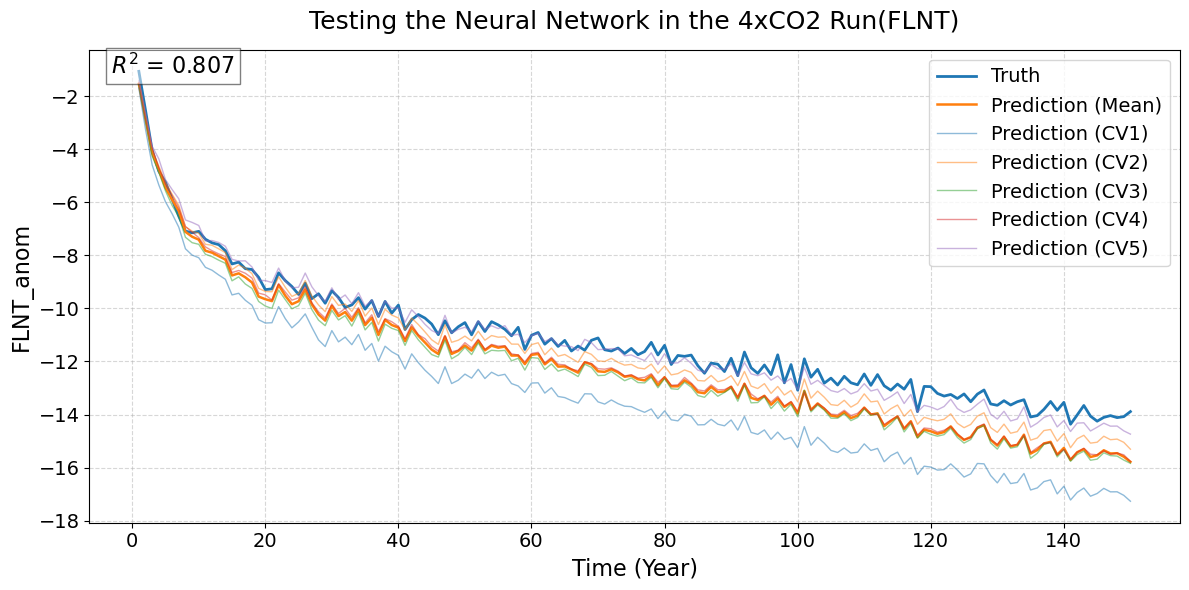

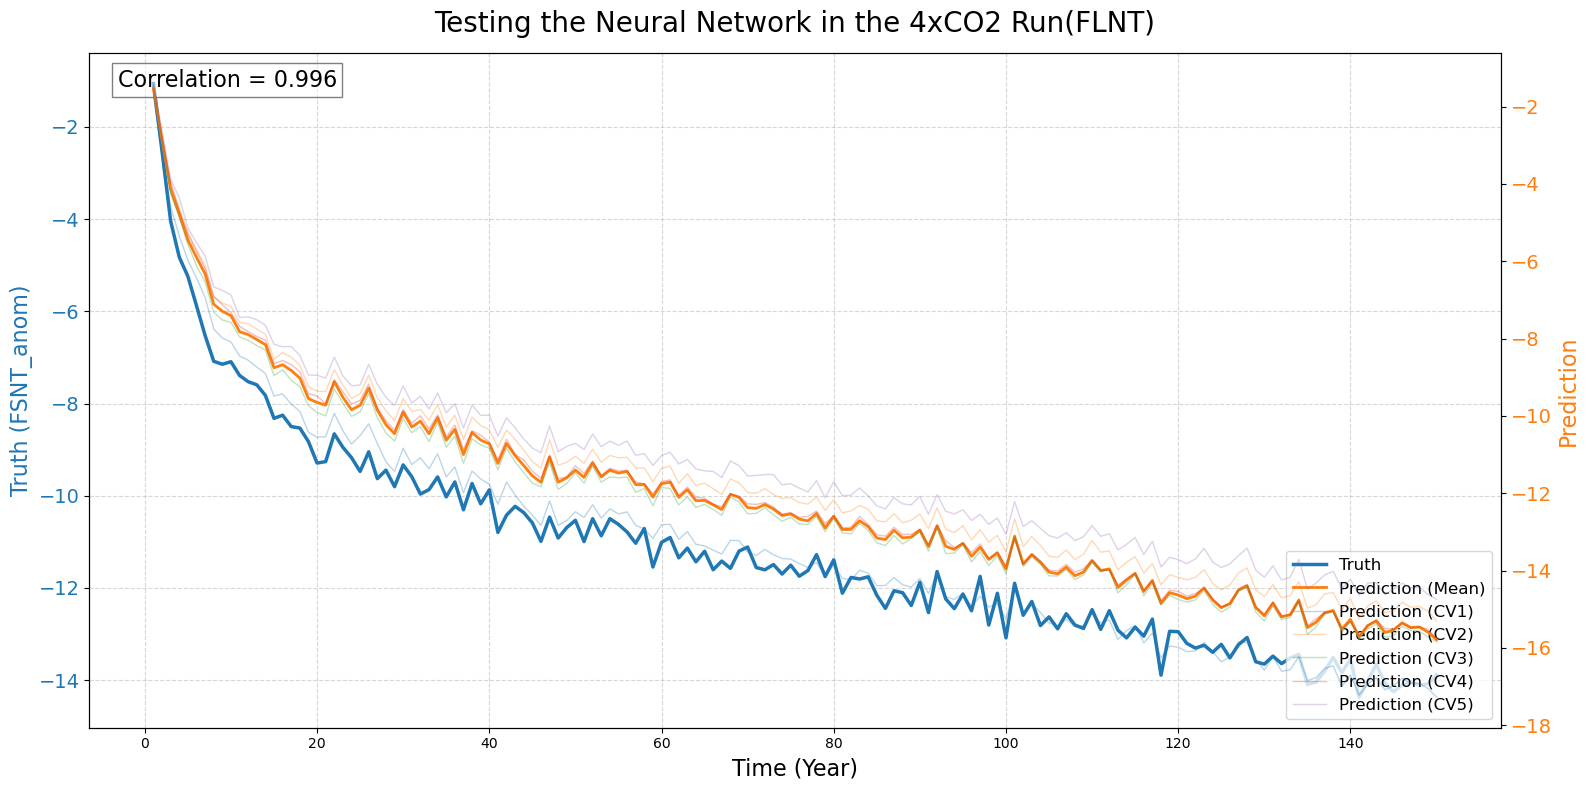

In [11]:
# plot_predictions(time_hist, TOA_hist, pred_hist_ALL,
#                 "Testing the Neural Network in the Historical Run")


plot_predictions(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run(FLNT)")


plot_predictions_twin_axes(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run(FLNT)")



▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL
    Analyzing model: model_fold1_ens1.h5


2025-08-05 03:56:08.886398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-08-05 03:56:10.619507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-08-05 03:56:12.198146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-08-05 03:56:13.733516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-08-05 03:56:15.157823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_historical.npy


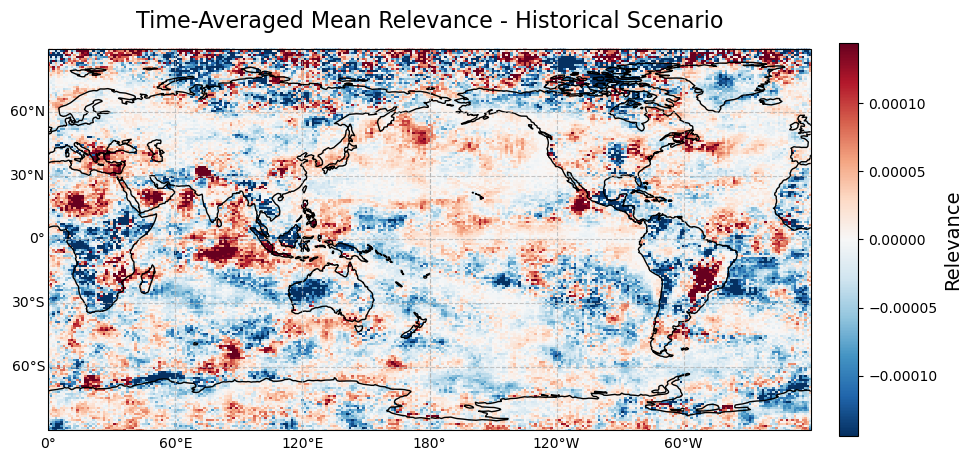


▶️ PROCESSING LRP FOR SCENARIO: 4XCO2
    Analyzing model: model_fold1_ens1.h5


2025-08-05 03:56:18.605030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-08-05 03:56:20.089008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-08-05 03:56:21.478389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-08-05 03:56:22.875320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-08-05 03:56:24.299444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_4xCO2.npy


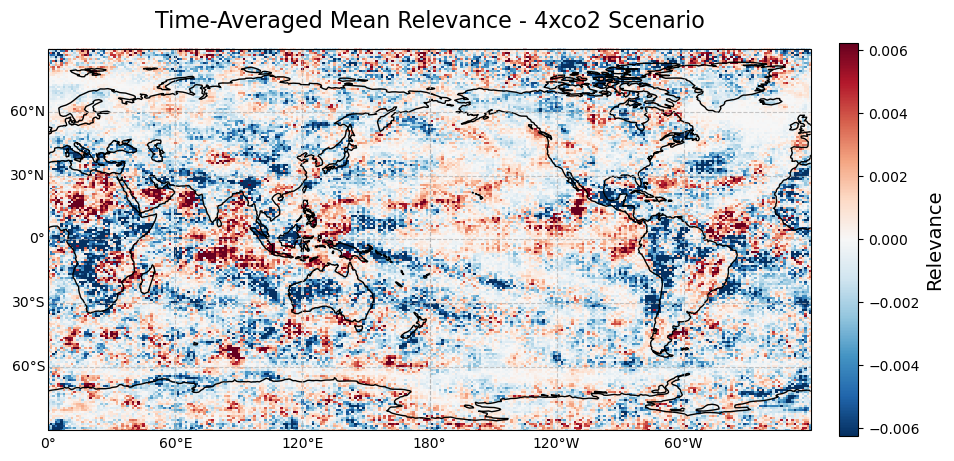

In [12]:
def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance"):
    """
    Plots a 2D global map using Cartopy, centered on the Pacific Ocean,
    with a tight, percentile-based color scale.
    """
    # Set color scale limit based on the 98th percentile to see patterns clearly
    vmax = np.nanpercentile(np.abs(data2d), 95)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

def ensemble_lrp_analyze(model_dir, num_folds, data_to_analyze):
    """
    Loads each model in an ensemble, generates its LRP map, and returns
    the averaged map from all models.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)}")
        try:
            model = load_model(model_path)
            # The analyzer needs the model without the final activation if it's not linear
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    # Stack along a new axis and compute the mean across the folds
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- 4. Main LRP Analysis and Plotting ---
TEST_SCENARIOS = {
    "historical": TS_hist_norm,
    "4xCO2": TS_4xCO2_norm
}

for scenario, data in TEST_SCENARIOS.items():
    print(f"\n======================================================")
    print(f"▶️ PROCESSING LRP FOR SCENARIO: {scenario.upper()}")
    print(f"======================================================")
    
    # Generate the full [time, lat, lon] attribution map
    attribution_map = ensemble_lrp_analyze(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data
    )
    
    if attribution_map is not None:
        # Squeeze out the channel dimension for saving and plotting
        attribution_map = attribution_map.squeeze()
        
        # Save the full attribution map for future analyses
        output_filename = f"attribution_map_{scenario}.npy"
        np.save(output_filename, attribution_map)
        print(f"✅ Full attribution map saved to: {output_filename}")
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} Scenario"
        )